### Notebook for the ENS Challenge Data 2022 - Qube Research & Technologies :


The link to the challenge : 

https://challengedata.ens.fr/participants/challenges/72/ 


My rank : 67

### Data Preparation : 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


path = '' 

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

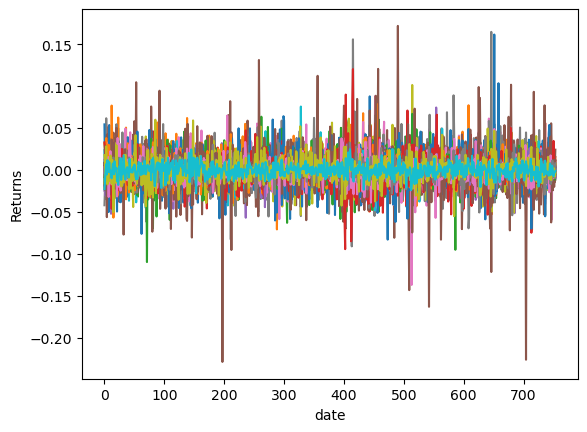

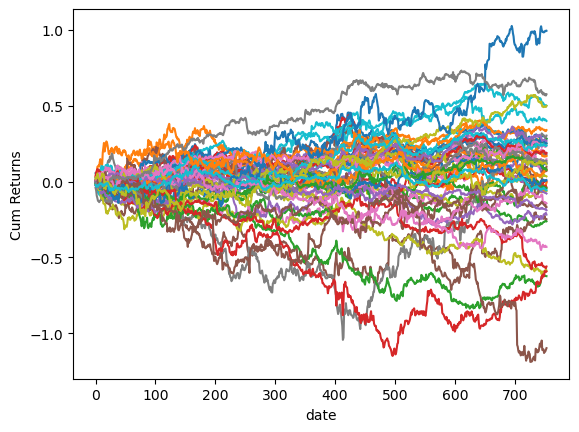

In [15]:
# The return and cumulative returns of the 50 stocks from the training data set over the three year period 

X_train.T.plot(legend=False,ylabel='Returns')
plt.show() # 753 days
X_train.T.cumsum().plot(legend=False , ylabel='Cum Returns')
plt.show() # 753 days


#####  Data Transformation for Vect Implementation

In [16]:
# we reshape the data  into a DataFrame with index (date, stock) and columns the lagged return values of the stock at time "date-1, ..., date-250".

X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], axis=1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')
display(X_train_reshape)

timeLag             1         2         3         4         5         6    \
date stocksID                                                               
250  0         0.000103  0.012387  0.011243  0.002595 -0.008509 -0.002711   
     1        -0.000982  0.003932  0.000050  0.001616 -0.003902 -0.001686   
     2         0.009301  0.003914  0.004995  0.001539  0.001452  0.002809   
     3         0.006515 -0.006553  0.009464  0.005204  0.004227 -0.005438   
     4        -0.006223  0.005415  0.014643  0.005195  0.004489  0.002695   
...                 ...       ...       ...       ...       ...       ...   
753  45        0.009786 -0.001861  0.012294 -0.023981  0.004069  0.000148   
     46       -0.008842  0.003698  0.005138 -0.004295 -0.010509  0.010230   
     47       -0.008607  0.006122 -0.007828 -0.008224  0.011357 -0.012855   
     48       -0.007519  0.001956  0.001903  0.001535  0.000695  0.004107   
     49       -0.002816 -0.002696 -0.007145 -0.001814  0.004331  0.005457   

timeLag             7         8         9         10   ...       241  \
date stocksID                                          ...             
250  0         0.008934  0.006571 -0.018546 -0.008353  ...  0.009119   
     1         0.008810  0.001585 -0.000745 -0.002155  ...  0.001664   
     2         0.005177 -0.006942 -0.013340 -0.008071  ...  0.007416   
     3         0.008861  0.004025 -0.012432 -0.006100  ...  0.003807   
     4         0.007609  0.011437 -0.004804  0.039274  ...  0.014404   
...                 ...       ...       ...       ...  ...       ...   
753  45       -0.062300  0.040002 -0.003475 -0.016284  ...  0.003808   
     46        0.006846  0.017514 -0.010796 -0.026356  ... -0.012077   
     47        0.000346 -0.016681  0.008247 -0.002723  ...  0.007291   
     48       -0.011879  0.000526  0.003178 -0.010654  ...  0.010960   
     49        0.000633 -0.005819  0.007592 -0.002003  ... -0.024003   

timeLag             242       243       244       245       246       247  \
date stocksID                                                               
250  0        -0.008451  0.007120 -0.011745  0.009092 -0.005110 -0.016676   
     1        -0.002747  0.009994 -0.001293  0.012912 -0.004055 -0.006820   
     2         0.001600  0.007640 -0.000637 -0.001353 -0.009522 -0.003425   
     3        -0.010636  0.012446 -0.011980  0.002485 -0.017981 -0.010899   
     4        -0.005255 -0.008182 -0.004614  0.007082  0.007872 -0.003515   
...                 ...       ...       ...       ...       ...       ...   
753  45       -0.003027  0.002522 -0.006594 -0.000489  0.054751 -0.012180   
     46       -0.002215  0.027569  0.021476  0.003874 -0.001690  0.012346   
     47        0.000369  0.000962 -0.005902  0.001067  0.013055  0.015432   
     48       -0.012003 -0.001969  0.030976 -0.000712  0.009795 -0.006842   
     49        0.001416  0.003348 -0.003685 -0.002267 -0.006733  0.000575   

timeLag             248       249       250  
date stocksID                                
250  0        -0.010776 -0.013002 -0.018647  
     1         0.012173 -0.022280 -0.008254  
     2        -0.006044 -0.013629 -0.008404  
     3        -0.008568 -0.006981 -0.022734  
     4        -0.007991 -0.008315 -0.024546  
...                 ...       ...       ...  
753  45        0.019142 -0.023184 -0.001315  
     46        0.007502  0.011425 -0.001580  
     47        0.023533 -0.022811 -0.001053  
     48        0.000464  0.015894 -0.003321  
     49        0.000735 -0.020917 -0.004808  

[25200 rows x 250 columns]

The motivation behind is that, given model parameters 'A' and 'beta', the associated predictions for Y_train are simply given by **Ypred = ( X_train_reshape @ A @ beta ).unstack().T**

## Utils Functions & Metric 

In [17]:
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    if any(Error.unstack() > 1e-6):
        bool = False
     
    return bool

$\text{Metric}(A, \beta) := \frac{1}{504} \sum_{t=250}^{753} \frac{\langle \tilde{S}_t, \tilde{R}_t \rangle}{\|\tilde{S}_t\| \|\tilde{R}_t\|}$


In [18]:
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T         
    Ytrue = Y_train
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean()

    return  meanOverlap  

In [19]:
#given a Stiefel matrix A, return the beta with minimal mean square prediction error on the training data set

def fitBeta(A):
    
    predictors = X_train_reshape @ A 
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()

## The Banchmark Model

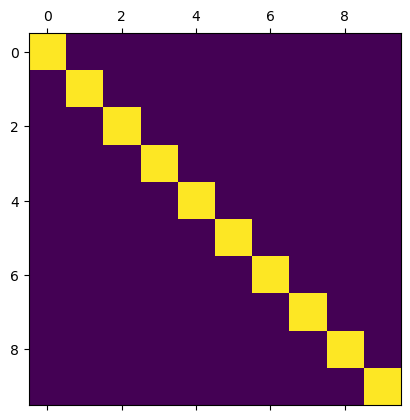

In [20]:
# uniformly random Stiefel matrix A
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return randomStiefel

A = randomA()
plt.matshow(A.T@A)
plt.show()

-Here's the code for a Banchmark solution, as shown in the challenge description. 

In [21]:
Niter = 10  # 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    A = randomA()
    beta = fitBeta(A)
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta 

0 metric_train: 0.02331346933035976
1 metric_train: 0.03319696206337412
3 metric_train: 0.03530204860763571
7 metric_train: 0.039995449146626054


## Postprocessing

In [22]:
def parametersTransform(A, beta, D=250, F=10):
    # From (A,beta) to csv format for submission
    if A.shape != (D, F):
        print('A has not the good shape')
        return
    
    if beta.shape[0] != F:
        print('beta has not the good shape')
        return        
    
    output = np.hstack( (np.hstack([A.T, beta.reshape((F, 1))])).T )
    
    return output


# random submission example
np.random.seed(1234)

A = randomA()
beta = np.random.rand(10)

# from output to csv file...
output = parametersTransform(A, beta)
pd.DataFrame(output).to_csv(path + 'randomSubmission.csv')

# ... and back
output_fromCsv = pd.read_csv(path + 'randomSubmission.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))

### Optimization problems on the Stiefel manifold


The problem proposed in the challeenge can be reformulated as an optimization under a Stiefel manifold :

$\underset{A, \beta}{\text{maximize}} \, \frac{1}{504} \sum_{t=250}^{753} \frac{\langle \tilde{S}_t, \tilde{R}_t \rangle}{\|\tilde{S}_t\| \|\tilde{R}_t\|} \quad \text{subject to} \quad A^T A = I$

The solver for this type of problem is implemented in the python library **pystmopt**.


Link: https://pypi.org/project/pystmopt/


In [23]:
import numpy as np
import scipy as sp
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Import manifolds and solvers
from pystop.manifold import Stiefel
from pystop.manifold import Euclidean
from pystop.solver import SLPG_smooth

n = 250
p = 10
r=50
M = Stiefel(n,p)
E= Euclidean((1,10))
def cosine_grad(yh, y):
    
    yh = yh[0] + 1e-8 # Add a small constant to avoid 0 vectors
    y = y + 1e-8
    # https://math.stackexchange.com/questions/1923613/partial-derivative-of-cosine-similarity
    norm_yh = np.linalg.norm(yh)
    norm_y = np.linalg.norm(y)
    mul_norms = norm_yh * norm_y
    cosine = (yh * y).sum() / mul_norms
    d_yh = (y / mul_norms) - (cosine * (yh / norm_yh**2))
    loss = np.abs(1-cosine).sum()
    return -d_yh
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T         
    Ytrue = Y_train
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean()

    return  meanOverlap  
def p_(i):
    global X_train_reshape
    return X_train_reshape[50*i:(i+1)*50].T.values
def ptrue(i):
    return Y_train[str(250+i)]

def obj_fun1(A):
    global beta
    grad=sum([p_(t)@(np.array([cosine_grad(beta@A.T@p_(t),ptrue(t)).T]).T)@beta/504 for t in range(504)]) # X_train_reshape 
    return-metric_train(A, beta[0]),grad
def obj_fun2(beta):
    global A
    grad=sum([A.T@p_(t)@cosine_grad(beta@A.T@p_(t),ptrue(t))/504 for t in range(504)])
    return-metric_train(A, beta[0]),grad
    

In [24]:
# Initial point is the banchmark solution : 

A=A_QRT 

In [26]:
# Optimization : 

n_iter=10  # 1000 
beta=np.array([10*[1]])
loss=[]
coef=[]
for i in range(n_iter):
    print("iteration ===> "+str(i))
    A,out_dict=SLPG_smooth(obj_fun1, M,maxit=1,Xinit=A)
    beta,out_dict=SLPG_smooth(obj_fun2, E,maxit=1,Xinit=beta)
    loss.append(-metric_train(A, beta[0]))
    coef.append((A,beta))

iteration ===> 0
Iter:0    fval:-3.330e-02   kkts:1.423e-01    feas:6.096536e-16
Post-processing
Iter:0    fval:-3.330e-02   kkts:1.423e-01    feas:2.495895e-15
Iter:0    fval:-3.336e-02   kkts:1.212e-02    feas:0.000000e+00
Post-processing
Iter:0    fval:-3.336e-02   kkts:1.212e-02    feas:0.000000e+00
iteration ===> 1
Iter:0    fval:-3.407e-02   kkts:1.421e-01    feas:1.168447e-15
Post-processing
Iter:0    fval:-3.407e-02   kkts:1.421e-01    feas:2.435009e-15
Iter:0    fval:-3.413e-02   kkts:1.209e-02    feas:0.000000e+00
Post-processing
Iter:0    fval:-3.413e-02   kkts:1.209e-02    feas:0.000000e+00
iteration ===> 2
Iter:0    fval:-3.483e-02   kkts:1.418e-01    feas:7.877918e-16
Post-processing
Iter:0    fval:-3.483e-02   kkts:1.418e-01    feas:2.371616e-15
Iter:0    fval:-3.489e-02   kkts:1.206e-02    feas:0.000000e+00
Post-processing
Iter:0    fval:-3.489e-02   kkts:1.206e-02    feas:0.000000e+00
iteration ===> 3
Iter:0    fval:-3.559e-02   kkts:1.415e-01    feas:8.722810e-16
Post

In [27]:
# from output to csv file...
output = parametersTransform(A, beta[0])
pd.DataFrame(output).to_csv('submission1.csv')